# 线性神经网络

## 矢量化加速

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [3]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [ ]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

# '0.04653 sec'

'0.04653 sec'

In [ ]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

# '0.00042 sec'

'0.00042 sec'

## 正态分布与平方损失

In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

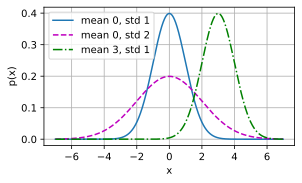

In [7]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# 线性回归的从零开始实现

In [8]:
import random
import torch
from d2l import torch as d2l

In [9]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
print('features:', features[0],'\nlabel:', labels[0])

# features: tensor([0.7858, 0.5545]) 
# label: tensor([3.8894])

features: tensor([0.7858, 0.5545]) 
label: tensor([3.8894])


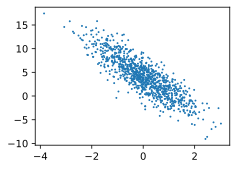

In [11]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [12]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [ ]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

# tensor([[-0.7322, -0.2723],
#         [ 1.4931, -1.9721],
#         [-0.6445, -0.5265],
#         [ 0.5830, -0.9340],
#         [-0.1465,  0.8492],
#         [ 0.9184,  0.2116],
#         [-1.6982,  0.2091],
#         [ 0.2086, -1.1105],
#         [-0.0598, -0.2561],
#         [ 0.1577, -0.5107]]) 
#  tensor([[ 3.6506],
#         [13.8853],
#         [ 4.7125],
#         [ 8.5456],
#         [ 1.0208],
#         [ 5.3259],
#         [ 0.0754],
#         [ 8.3850],
#         [ 4.9423],
#         [ 6.2505]])

tensor([[-0.7322, -0.2723],
        [ 1.4931, -1.9721],
        [-0.6445, -0.5265],
        [ 0.5830, -0.9340],
        [-0.1465,  0.8492],
        [ 0.9184,  0.2116],
        [-1.6982,  0.2091],
        [ 0.2086, -1.1105],
        [-0.0598, -0.2561],
        [ 0.1577, -0.5107]]) 
 tensor([[ 3.6506],
        [13.8853],
        [ 4.7125],
        [ 8.5456],
        [ 1.0208],
        [ 5.3259],
        [ 0.0754],
        [ 8.3850],
        [ 4.9423],
        [ 6.2505]])


In [14]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [15]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [16]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [17]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [ ]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

# epoch 1, loss 0.038509
# epoch 2, loss 0.000145
# epoch 3, loss 0.000050

epoch 1, loss 0.038509
epoch 2, loss 0.000145
epoch 3, loss 0.000050


In [ ]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

# w的估计误差: tensor([0.0004, 0.0006], grad_fn=<SubBackward0>)
# b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)

w的估计误差: tensor([0.0004, 0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


# 线性回归的简洁实现

In [20]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [30]:
features, labels

(tensor([[ 0.1359,  0.2825],
         [-0.1158, -0.3886],
         [ 0.3948,  1.0754],
         ...,
         [-1.1201,  1.2823],
         [ 1.4249, -1.3324],
         [-1.1013,  1.2149]]),
 tensor([[ 3.5223e+00],
         [ 5.2869e+00],
         [ 1.3333e+00],
         [ 8.6807e+00],
         [ 2.2963e+00],
         [ 1.8450e+00],
         [ 4.3339e-01],
         [ 1.1400e+00],
         [-2.9980e+00],
         [ 5.5464e+00],
         [ 7.0246e+00],
         [ 3.7707e+00],
         [ 3.0713e-01],
         [ 6.4568e+00],
         [ 8.1420e+00],
         [ 1.2896e+01],
         [ 1.5496e+00],
         [ 1.2061e+01],
         [ 5.2329e+00],
         [ 3.1429e+00],
         [ 5.9862e+00],
         [ 2.7428e-02],
         [ 3.0566e+00],
         [-1.7948e-01],
         [ 9.4812e-01],
         [ 2.8962e+00],
         [ 3.9062e+00],
         [ 1.0867e+01],
         [ 1.4093e+00],
         [ 2.3987e+00],
         [ 4.7152e+00],
         [-1.4358e+00],
         [ 3.7836e+00],
         [ 1.0064e

In [21]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [ ]:
next(iter(data_iter))

# [tensor([[ 1.4540,  1.0945],
#          [-0.9852, -0.4931],
#          [ 0.1719,  1.1320],
#          [-0.3929,  0.6562],
#          [-0.4562,  1.0106],
#          [-0.2153,  0.8735],
#          [ 0.4067, -1.0178],
#          [-1.6688, -0.7568],
#          [ 0.7937, -0.7819],
#          [-0.5027, -0.1525]]),
#  tensor([[ 3.3931],
#          [ 3.9145],
#          [ 0.7133],
#          [ 1.1884],
#          [-0.1435],
#          [ 0.8088],
#          [ 8.4830],
#          [ 3.4428],
#          [ 8.4733],
#          [ 3.7208]])]

[tensor([[ 1.4540,  1.0945],
         [-0.9852, -0.4931],
         [ 0.1719,  1.1320],
         [-0.3929,  0.6562],
         [-0.4562,  1.0106],
         [-0.2153,  0.8735],
         [ 0.4067, -1.0178],
         [-1.6688, -0.7568],
         [ 0.7937, -0.7819],
         [-0.5027, -0.1525]]),
 tensor([[ 3.3931],
         [ 3.9145],
         [ 0.7133],
         [ 1.1884],
         [-0.1435],
         [ 0.8088],
         [ 8.4830],
         [ 3.4428],
         [ 8.4733],
         [ 3.7208]])]

In [34]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [35]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [36]:
loss = nn.MSELoss()

In [37]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [56]:
# 加载所需的库
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

# 设置随机种子以确保结果可复现
torch.manual_seed(0)

# 生成数据
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

# 转化为torch数据集
dataset = data.TensorDataset

# 将数据集加载为DataLoader，为实现随机小批量SGD
data_iter = data.DataLoader(dataset(features, labels), batch_size=10, shuffle=True)

# 定义模型
# 第一层2个节点表示LR的解释变量
# 第二层1个节点表示LR的被解释变量
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

# 定义损失函数
loss = nn.MSELoss()

# 初始化模型参数（非必需）
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

# 定义优化器
# 指定参数，后续step会根据梯度更新参数
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter:
        # 计算损失函数
        l = loss(net(X), y)
        # 梯度清零
        trainer.zero_grad()
        # 计算梯度
        l.backward()
        # 根据梯度更新函数
        trainer.step()
    # 计算训练集上的损失
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

epoch 1, loss 0.000247
epoch 2, loss 0.000093
epoch 3, loss 0.000094
epoch 4, loss 0.000093
epoch 5, loss 0.000093
epoch 6, loss 0.000094
epoch 7, loss 0.000093
epoch 8, loss 0.000093
epoch 9, loss 0.000093
epoch 10, loss 0.000093
w的估计误差： tensor([-2.2650e-05, -6.0797e-04])
b的估计误差： tensor([-0.0001])


# 图像数据集

In [58]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [60]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="./data", train=False, transform=trans, download=True)

100.0%
100.0%
100.0%
100.0%


In [ ]:
len(mnist_train), len(mnist_test)

# (60000, 10000)

(60000, 10000)

In [ ]:
mnist_train[0][0].shape

# torch.Size([1, 28, 28])

torch.Size([1, 28, 28])

In [63]:
mnist_train[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [64]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [65]:
get_fashion_mnist_labels([0, 1])

['t-shirt', 'trouser']

In [66]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

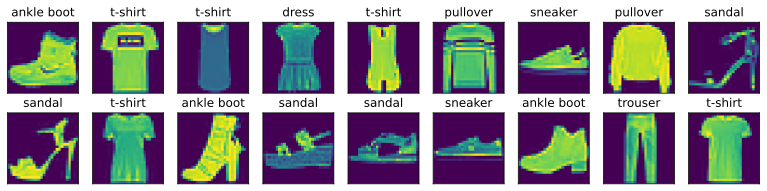

In [67]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [68]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [ ]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

# '3.76 sec'

'3.76 sec'

In [70]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [ ]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

# 100.0%
# 100.0%
# 100.0%
# 100.0%
# torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64

100.0%
100.0%
100.0%
100.0%


torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# softmax从零实现

In [72]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [78]:
torch.zeros(10).reshape(1, 10)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [79]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [ ]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

# (tensor([[5., 7., 9.]]),
#  tensor([[ 6.],
#          [15.]]))

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [81]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [ ]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

# (tensor([[0.0725, 0.0984, 0.3000, 0.3334, 0.1957],
#          [0.1963, 0.2170, 0.4578, 0.0399, 0.0889]]),
#  tensor([1., 1.]))

(tensor([[0.0725, 0.0984, 0.3000, 0.3334, 0.1957],
         [0.1963, 0.2170, 0.4578, 0.0399, 0.0889]]),
 tensor([1., 1.]))

In [83]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [ ]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

# tensor([0.1000, 0.5000])

tensor([0.1000, 0.5000])

In [ ]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

# tensor([2.3026, 0.6931])

tensor([2.3026, 0.6931])

In [86]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [ ]:
accuracy(y_hat, y) / len(y)

# 0.5

0.5

In [88]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [89]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [90]:
evaluate_accuracy(net, test_iter)

0.0675

In [91]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [92]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [93]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [96]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

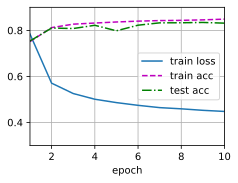

In [97]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

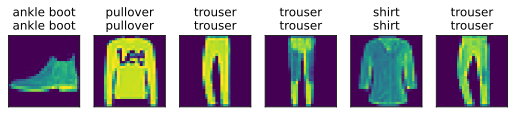

In [98]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# softmax回归的简洁实现

In [99]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [100]:
# 定义模型
net = nn.Sequential(
    nn.Flatten(),  # 将输入展平为一维向量
    nn.Linear(784, 256),  # 输入层到隐藏层
)

# 初始化模型参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
)

In [101]:
loss = nn.CrossEntropyLoss(reduction='none')

In [102]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

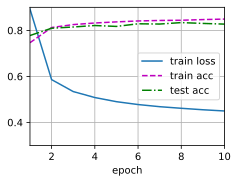

In [104]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
num_epochs = 10
for i in range(num_epochs):
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        trainer.zero_grad()
        l.mean().backward()
        trainer.step()
        print(f'epoch {i + 1}, loss {l.mean():f}')

epoch 1, loss 17.497681
epoch 1, loss 20.532040
epoch 1, loss 15.099433
epoch 1, loss 22.281982
epoch 1, loss 14.618047
epoch 1, loss 11.928303
epoch 1, loss 16.217636
epoch 1, loss 18.695534
epoch 1, loss 23.406059
epoch 1, loss 21.817429
epoch 1, loss 25.557646
epoch 1, loss 24.852968
epoch 1, loss 17.622845
epoch 1, loss 17.229679
epoch 1, loss 13.216911
epoch 1, loss 18.687378
epoch 1, loss 9.255341
epoch 1, loss 22.093647
epoch 1, loss 15.472166
epoch 1, loss 16.585238
epoch 1, loss 18.654419
epoch 1, loss 22.582678
epoch 1, loss 13.847507
epoch 1, loss 19.096596
epoch 1, loss 19.098379
epoch 1, loss 21.292013
epoch 1, loss 17.954889
epoch 1, loss 19.938313
epoch 1, loss 15.282287
epoch 1, loss 19.250402
epoch 1, loss 18.914206
epoch 1, loss 14.460877
epoch 1, loss 13.909687
epoch 1, loss 14.980868
epoch 1, loss 17.270493
epoch 1, loss 16.418543
epoch 1, loss 21.750477
epoch 1, loss 15.081998
epoch 1, loss 14.872564
epoch 1, loss 14.868912
epoch 1, loss 14.827732
epoch 1, loss 17.